# ⋆. 𐙚 ̊ FANtastic Trio Member  ̊ 𐙚⋆.

*   นางสาวมณิสรา แซ่จัน รหัสนิสิต 66102010151
*   นายฐิติวัฒน์ ฮาบสุวรรณ รหัสนิสิต 66102010238
*   นางสาวเอมี่หลุยส์ บราวน์ รหัสนิสิต 66102010572

**Flowchart กระบวนการทำงานทั้งหมด**

<div style="display: flex; justify-content: space-between;">
        <img src="https://drive.google.com/uc?export=view&id=1F1itChWgEYHgpyP2lm-yKgsxEMStmoH6" height="500">
</div>

# Connecting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installation & Import Libraries

In [ ]:
!pip install mediapipe ultralytics

In [ ]:
import os, math
import glob
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from ultralytics import YOLO
import mediapipe as mp

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


# Load Yoga Dataset

โหลดชุดข้อมูลจาก kaggle: [Yoga Dataset](https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset)

In [ ]:
import kagglehub
import shutil

# Download latest version
path = kagglehub.dataset_download("niharika41298/yoga-poses-dataset")

print("Path to dataset files:", path)

dst = "/content/yoga-poses-dataset"

shutil.copytree(path, dst, dirs_exist_ok=True)

print("Copied dataset to:", dst)

100%|██████████| 288M/288M [00:14<00:00, 20.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/niharika41298/yoga-poses-dataset/versions/1
Copied dataset to: /content/yoga-poses-dataset


# ˖⋆˚✿˖° Section 1: Config & Thresholds

รวมพวก PATH, ค่า config, และ threshold ที่เกี่ยวกับมุม

In [ ]:
# ROOT ของ dataset
DATASET_ROOT = "/content/yoga-poses-dataset/DATASET"
TRAIN_PATH = os.path.join(DATASET_ROOT, "TRAIN")
TEST_PATH = os.path.join(DATASET_ROOT, "TEST")

# ROOT ของ incorrect dataset
INCORRECT_PATH = "/content/drive/MyDrive/DATASET_ROOT/INCORRECT"

In [ ]:
# Threshold มุมตามที่ลอง print ค่ามาดูแล้วกำหนดค่าเอง
POSE_ANGLE_THRESHOLDS = {
    # Tree Pose
    "tree_left": {   # ยกขาซ้าย
        "left_knee": (20, 60),     # ขาซ้ายงอ
        "right_knee": (160, 180),  # ขาขวาตรง
        "left_elbow": (150, 180),
        "right_elbow": (150, 180),
        "left_hip": (90, 130),
        "right_hip": (160, 180)
    },
    "tree_right": {  # ยกขาขวา
        "left_knee": (160, 180),
        "right_knee": (20, 60),
        "left_elbow": (150, 180),
        "right_elbow": (150, 180),
        "left_hip": (160, 180),
        "right_hip": (90, 130)
    },

    # Warrior II Pose
    "warrior2_left": {  # ขาซ้ายงอ
        "left_knee": (80, 110),
        "right_knee": (160, 180),
        "left_hip": (70, 125),
        "right_hip": (70, 125),
        "left_elbow": (160, 180),
        "right_elbow": (160, 180),
        "left_shoulder": (60, 120),
        "right_shoulder": (60, 120)
    },
    "warrior2_right": {  # ขาขวางอ
        "right_knee": (80, 110),
        "left_knee": (160, 180),
        "left_hip": (70, 125),
        "right_hip": (70, 125),
        "left_elbow": (160, 180),
        "right_elbow": (160, 180),
        "left_shoulder": (60, 120),
        "right_shoulder": (60, 120)
    },

    # Downward Dog
    "downdog": {
        "left_knee":     (150, 180),
        "right_knee":    (150, 180),
        "left_elbow":    (145, 180),
        "right_elbow":   (145, 180),
        "left_hip":      (30, 110),
        "right_hip":     (30, 110)
    },

    # Plank
    "plank": {
        "left_knee": (160, 180),
        "right_knee": (160, 180),
        "left_elbow": (160, 180),
        "right_elbow": (160, 180),
        "left_hip": (150, 180),
        "right_hip": (150, 180),
        "left_shoulder": (70, 110),
        "right_shoulder": (70, 110)
    },

    # Goddess
    "goddess": {
        "left_knee": (85,140),
        "right_knee": (85,140),
        "left_hip": (70, 120),
        "right_hip": (70, 120),
        "left_elbow": (40, 60),
        "right_elbow": (40, 60),
        "left_shoulder": (20, 50),
        "right_shoulder": (20, 50)
    }
}

# joints ที่เราจะใช้เป็น features
FEATURE_COLS = [
    "left_knee", "right_knee",
    "left_elbow", "right_elbow",
    "left_hip", "right_hip",
    "left_shoulder", "right_shoulder"
]

# mapping index ของ Mediapipe Pose กับ joint name
# https://developers.google.com/mediapipe/solutions/vision/pose_landmarker
MP_KEYPOINT_IDX = {
    "nose": 0,
    "left_shoulder": 11,
    "right_shoulder": 12,
    "left_elbow": 13,
    "right_elbow": 14,
    "left_wrist": 15,
    "right_wrist": 16,
    "left_hip": 23,
    "right_hip": 24,
    "left_knee": 25,
    "right_knee": 26,
    "left_ankle": 27,
    "right_ankle": 28,
}

# COCO-style skeleton
COCO_CONNECTIONS = [
    ("left_shoulder",  "left_elbow"),
    ("left_elbow",     "left_wrist"),
    ("right_shoulder", "right_elbow"),
    ("right_elbow",    "right_wrist"),

    ("left_hip",       "left_knee"),
    ("left_knee",      "left_ankle"),
    ("right_hip",      "right_knee"),
    ("right_knee",     "right_ankle"),

    ("left_shoulder",  "right_shoulder"),
    ("left_hip",       "right_hip"),

    ("left_shoulder",  "left_hip"),
    ("right_shoulder", "right_hip")
]

# ˖⋆˚✿˖° Section 2: Angle Functions

ฟังก์ชัน `calculate_angle()`: ฟังก์ชันสำหรับ คำนวณมุมที่จุด b โดยจุด a และ c เป็นปลายของเส้นสองเส้นที่ประกอบกันเป็นมุมที่ b

In [ ]:
def calculate_angle(a, b, c):
    """
    คำนวณมุมที่ joint b
    a, b, c: tuple หรือ list ของ (x, y) coordinates
    return: angle (0–180 degree)
    """

    # แปลงจุดแต่ละจุดเป็น numpy array
    a = np.array(a[:2]) # [:2] เพื่อให้แน่ใจว่าเอาแค่ x, y
    b = np.array(b[:2])
    c = np.array(c[:2])

    # สร้างเวกเตอร์ BA และ BC
    ba = a - b
    bc = c - b

    # ความยาวของ vector ba คูณกับ ความยาวของ vector bc +1e-6 เพื่อ ป้องกันหารด้วยศูนย์
    denom = (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)

    # dot product ของ vector ba กับ bc หารด้วย denom ได้ค่า cosine ของมุมที่ b
    cosang = np.dot(ba, bc) / denom
    cosang = np.clip(cosang, -1.0, 1.0) # ป้องกันค่า cosang เกินขอบเขต [-1, 1] เพราะบางครั้ง precision ของ float ทำให้ arccos error
    angle = np.degrees(np.arccos(cosang)) # คืนค่า มุมเป็น radians แปลงเป็น องศา
    return float(angle)

**MediaPipes 33 keypoints**

ข้อมูลจาก: [
Google AI for Developers](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker)

<div style="display: flex; justify-content: space-between;">
        <img src="https://drive.google.com/uc?export=view&id=1RuTLplJa7xWLV12A3f_8xI4cMeKi-LGG" height="400">
</div>

ฟังก์ชัน `compute_angles_from_keypoints()`: คำนวณมุมต่าง ๆ ของร่างกายจากโครงร่าง (pose landmarks) ที่ได้จาก MediaPipe
โดยมันจะคำนวณมุม 8 ตำแหน่ง ได้แก่
1. ข้อศอกซ้าย
1. ข้อศอกขวา
1. ไหล่ซ้าย
1. ไหล่ขวา
1. เข่าซ้าย
1. เข่าขวา
1. สะโพกซ้าย
1. สะโพกขวา

In [ ]:
def compute_angles_from_keypoints(keypoints_dict):
    """
    keypoints_dict: {"left_knee": (x,y), ...}
    return: dict ของ angles ตาม FEATURE_COLS
    """
    # ทำให้การเข้าถึง keypoint ทำได้ง่ายขึ้น เช่น g("left_knee") = keypoints_dict["left_knee"]
    def g(name):
        return keypoints_dict[name]

    # สร้าง dictionary เก็บมุมต่าง ๆ
    angles = {}

    # เข่า
    angles["left_knee"] = calculate_angle(g("left_hip"), g("left_knee"), g("left_ankle"))
    angles["right_knee"] = calculate_angle(g("right_hip"), g("right_knee"), g("right_ankle"))
    # ศอก
    angles["left_elbow"] = calculate_angle(g("left_shoulder"), g("left_elbow"), g("left_wrist"))
    angles["right_elbow"] = calculate_angle(g("right_shoulder"), g("right_elbow"), g("right_wrist"))
    # สะโพก
    angles["left_hip"] = calculate_angle(g("left_shoulder"), g("left_hip"), g("left_knee"))
    angles["right_hip"] = calculate_angle(g("right_shoulder"), g("right_hip"), g("right_knee"))
    # ไหล่
    angles["left_shoulder"] = calculate_angle(g("left_elbow"), g("left_shoulder"), g("left_hip"))
    angles["right_shoulder"] = calculate_angle(g("right_elbow"), g("right_shoulder"), g("right_hip"))
    return angles

# ˖⋆˚✿˖° Section 3: YOLO Crop + MediaPipe Keypoints

ในการทดลองประเมินประสิทธิภาพของโมเดล YOLO สำหรับงานตรวจจับบุคคล (person detection) ได้ทำการทดสอบทั้งหมด 6 รูปแบบ ได้แก่

1. YOLOv5 - ใช้คลาส person (class 0) จากโมเดลสำเร็จรูป
1. YOLOv5 - เทรนใหม่ด้วย person dataset
1. YOLOv8 - ใช้คลาส person (class 0) จากโมเดลสำเร็จรูป
1. YOLOv8 - เทรนใหม่ด้วย person dataset
1. YOLOv11 - ใช้คลาส person (class 0) จากโมเดลสำเร็จรูป
1. YOLOv11 - เทรนใหม่ด้วย person dataset

> จากผลการทดลอง เปรียบเทียบความแม่นยำและประสิทธิภาพโดยรวม พบว่า
โมเดลที่ให้ผลลัพธ์ดีที่สุดคือ `YOLOv11 แบบใช้คลาส person (class 0) จากโมเดลสำเร็จรูป`

ลิงก์ Colab ที่ได้มีการ Train YOLO แต่ละเวอร์ชันเปรียบเทียบกัน: [Comparison YOLO person detection](https://)

ชุดข้อมูลที่ใช้ Train: [Person Dataset](https://github.com/PSLeon24/AI_Exercise_Pose_Feedback/tree/main/yolov5_onlyPerson/person)

In [ ]:
# โหลด yolo11m.pt
yolo = YOLO("yolo11m.pt")

# เตรียม MediaPipe Pose
mp_pose = mp.solutions.pose # โมดูลสำหรับ ตรวจจับท่าทางของร่างกาย (pose estimation)
pose_model = mp_pose.Pose(static_image_mode=True, model_complexity=2) # สร้างโมเดล Pose estimation กำหนด ความซับซ้อนของโมเดล = 2

ฟังก์ชัน `crop_person_with_yolo()`
1. ใช้ YOLO11 ตรวจจับวัตถุประเภท `person`
1. เลือก bounding box ที่ใหญ่ที่สุด (คิดว่าเป็นคนหลักในภาพ)
1. เพิ่ม padding รอบ box เพื่อ crop ให้ครบตัว
1. ตัดภาพเฉพาะส่วนที่เป็นคน
1. คืนทั้งภาพที่ crop และตำแหน่ง bounding box
หรือคืน (None, None) หากไม่พบคน

In [ ]:
def crop_person_with_yolo(image):
    """
    ใช้ YOLO11 หา person แล้ว crop box ที่ใหญ่ที่สุด
    return: (crop_image, crop_box) หรือ (None, None) ถ้าไม่มีคน
    """
    results = yolo(image, classes=[0], verbose=False)  # 0 = person
    boxes = results[0].boxes  # ดึง bounding boxes ของ object ที่ detect ได้
    if boxes is None or len(boxes) == 0:  # ถ้าไม่มี box
        return None, None

    # แปลง tensor ของ bounding boxes เป็น numpy array
    xyxy = boxes.xyxy.cpu().numpy()

    # คำนวณ พื้นที่ของแต่ละ box ใช้หากล่องที่ใหญ่ที่สุด
    areas = [(x2 - x1) * (y2 - y1) for (x1, y1, x2, y2) in xyxy]
    max_idx = int(np.argmax(areas))
    x1, y1, x2, y2 = xyxy[max_idx]
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

    # ตรวจสอบให้ box อยู่ในขอบภาพ + padding
    h, w, _ = image.shape
    pad = 60
    x1 = max(0, x1 - pad)
    y1 = max(0, y1 - pad)
    x2 = min(w, x2 + pad)
    y2 = min(h, y2 + pad)

    # crop ภาพ
    crop = image[y1:y2, x1:x2]
    if crop.size == 0:
        return None, None

    crop_box = (x1, y1, x2, y2)
    return crop, crop_box # คืนค่าภาพ crop และตำแหน่งกล่อง

**pose_landmarks**
* ข้างในจะมี list ของ 33 จุด keypoints ตามมาตรฐาน Mediapipe Pose
* แต่ละ landmark มีค่า

```
landmark.x  # ตำแหน่ง x ในภาพ normalized (0.0 - 1.0)
landmark.y  # ตำแหน่ง y ในภาพ normalized (0.0 - 1.0)
landmark.z  # ตำแหน่ง z ในเชิงความลึก (negative คืออยู่หน้า)
landmark.visibility  # ความมั่นใจในการตรวจจับ (0.0 - 1.0)
```

In [ ]:
def mediapipe_keypoints_from_image(image):
    """
    image: BGR
    return:
      keypoints: dict {"left_knee": (x,y), ...}
      or None ถ้า detect ไม่ได้
    """
    # แปลงจาก BGR เป็น RGB
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # detect pose landmarks
    results = pose_model.process(rgb)
    # ถ้า ไม่พบ pose landmarks return None
    if not results.pose_landmarks:
        return None

    h, w, _ = image.shape # ความสูงและความกว้างของภาพ

    # list ของ landmark points ของ MediaPipe
    lm_list = results.pose_landmarks.landmark # แต่ละ landmark มีข้อมูล x, y (normalized 0–1), z, visibility

    # ดึง keypoints ที่ใช้เท่านั้น
    keypoints = {}
    # dictionary mapping ชื่อ joint ไป index ของ MediaPipe landmark
    for name, idx in MP_KEYPOINT_IDX.items():
        lm = lm_list[idx]
        x = lm.x * w
        y = lm.y * h
        keypoints[name] = (x, y)

    return keypoints

In [ ]:
def mediapipe_keypoints_from_image_for_train(image):
    """
    image: BGR
    return:
      keypoints: dict {"left_knee": (x,y), ...}
      or None ถ้า detect ไม่ได้
    """
    # แปลงจาก BGR เป็น RGB
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # detect pose landmarks
    results = pose_model.process(rgb)
    # ถ้า ไม่พบ pose landmarks return None
    if not results.pose_landmarks:
        return None

    h, w, _ = image.shape # ความสูงและความกว้างของภาพ

    # list ของ landmark points ของ MediaPipe
    lm_list = results.pose_landmarks.landmark # แต่ละ landmark มีข้อมูล x, y (normalized 0–1), z, visibility

    # 1) Extract raw pixel points
    keypoints = {}
    for name, idx in MP_KEYPOINT_IDX.items(): # dictionary mapping ชื่อ joint ไป index ของ MediaPipe landmark
        lm = lm_list[idx]
        x = lm.x * w     # pixel
        y = lm.y * h     # pixel
        keypoints[name] = (x, y)

    # 2) หา midpoint ของสะโพก (origin)
    left_hip = keypoints["left_hip"]
    right_hip = keypoints["right_hip"]
    origin_x = (left_hip[0] + right_hip[0]) / 2
    origin_y = (left_hip[1] + right_hip[1]) / 2

    # 3) คำนวณ torso-length (scale)
    left_shoulder = keypoints["left_shoulder"]
    torso_length = math.dist(left_shoulder, left_hip)

    if torso_length < 1:
        return None  # กัน error

    # 4) Normalize ทุกจุด
    keypoints_norm = {}
    for name, (x, y) in keypoints.items():
        x_n = (x - origin_x) / torso_length
        y_n = (y - origin_y) / torso_length
        keypoints_norm[name] = (x_n, y_n)

    return keypoints_norm

# ˖⋆˚✿˖° Section 4: สร้าง Angle Dataset + Train Pose Classifier

ฟังก์ชัน `classify_side_for_pose()` แปลงชื่อท่าทาง (pose label) จากชื่อโฟลเดอร์ ให้กลายเป็นชื่อท่าที่แยกซ้าย–ขวา เฉพาะท่า tree กับ warrior2 โดยอาศัย มุมเข่า เป็นตัวบอกว่าข้างไหนเป็นข้างที่ทำท่าอยู่

In [ ]:
def classify_side_for_pose(folder_label, angles):
    """
    แปลง label จากโฟลเดอร์ (tree / warrior2 / plank / downdog / goddess)
    ให้กลายเป็น label ที่ match กับ POSE_ANGLE_THRESHOLDS:
      tree -> tree_left / tree_right
      warrior2 -> warrior2_left / warrior2_right
      ที่เหลือ -> ตามชื่อเดิม
    ใช้ heuristic จากมุมเข่า
    """
    # tree
    if folder_label == "tree":
        lk = angles["left_knee"]
        rk = angles["right_knee"]
        # ถ้าซ้ายงอ (เล็กกว่า) tree_left
        if lk < rk:
            return "tree_left"
        else:
            return "tree_right"

    # warrior2
    if folder_label == "warrior2":
        lk = angles["left_knee"]
        rk = angles["right_knee"]
        # เข่างอจะมีมุมเล็กกว่า
        if lk < rk:
            return "warrior2_left"
        else:
            return "warrior2_right"

    # pose ที่ไม่ต้องแยกข้าง
    if folder_label in ["downdog", "plank", "goddess"]:
        return folder_label

    # fallback ถ้าเจอ label แปลก
    return folder_label

## Build Correct Angles CSV

ฟังก์ชัน `build_angles_csv()` ทำงานเป็น pipeline สำหรับสร้าง Dataset ของมุมข้อต่อร่างกาย (Pose Angle Dataset) จากชุดภาพ

1. อ่านโฟลเดอร์ภาพตาม class (pose)
1. อ่านทุกภาพใน class นั้น
1. Crop เฉพาะคนด้วย YOLO
1. ใช้ MediaPipe สร้าง keypoints
1. คำนวณมุมของข้อต่อต่าง ๆ
1. จัดหมวดหมู่ท่าทาง (ซ้าย/ขวา)
1. เก็บข้อมูลเป็น CSV

In [ ]:
def build_angles_csv(split_path, output_csv):
    """
    split_path: TRAIN หรือ TEST
    output_csv: path ที่จะเซฟ angles dataset
    """
    rows = []

    # Loop ผ่านทุก label folder
    for label in os.listdir(split_path):
        pose_dir = os.path.join(split_path, label)
        if not os.path.isdir(pose_dir):
            continue

        print(f"🧘 Processing class folder: {label}")
        # เลือกเฉพาะไฟล์รูป
        img_files = [f for f in os.listdir(pose_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))]

        # Loop ภาพทั้งหมดภายใน class
        for img_file in tqdm(img_files):
            img_path = os.path.join(pose_dir, img_file)
            # อ่านภาพ
            image = cv2.imread(img_path)
            if image is None:
                print(f"Failed to load image: {img_path}")
                continue

            # Crop คนด้วย YOLO
            crop_img, crop_box = crop_person_with_yolo(image)
            if crop_img is None:
                continue

            # ใช้ MediaPipe หา keypoints
            keypoints = mediapipe_keypoints_from_image_for_train(crop_img)
            if keypoints is None:
                continue

            # คำนวณมุมข้อต่อ
            angles = compute_angles_from_keypoints(keypoints)

            # แยก tree_left/right, warrior2_left/right
            pose_name = classify_side_for_pose(label, angles)

            # สร้าง 1 row สำหรับ CSV
            row = {
                "pose_folder_label": label,
                "pose_name": pose_name,
                "image_path": img_path
            }
            for col in FEATURE_COLS:
                row[col] = angles[col]

            # เพิ่ม row ลง dataset
            rows.append(row)

    # Save เป็น CSV
    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved {len(df)} samples to {output_csv}")

In [ ]:
build_angles_csv(TRAIN_PATH, "train_angles.csv")
build_angles_csv(TEST_PATH, "test_angles.csv")

🧘 Processing class folder: plank


100%|██████████| 266/266 [00:39<00:00,  6.78it/s]


🧘 Processing class folder: warrior2


100%|██████████| 252/252 [00:35<00:00,  7.16it/s]


🧘 Processing class folder: downdog


100%|██████████| 222/222 [00:28<00:00,  7.79it/s]


🧘 Processing class folder: goddess


100%|██████████| 180/180 [00:23<00:00,  7.83it/s]


🧘 Processing class folder: tree


100%|██████████| 160/160 [00:22<00:00,  7.01it/s]


✅ Saved 1004 samples to train_angles.csv
🧘 Processing class folder: plank


100%|██████████| 115/115 [00:17<00:00,  6.68it/s]


🧘 Processing class folder: warrior2


100%|██████████| 109/109 [00:15<00:00,  7.00it/s]


🧘 Processing class folder: downdog


100%|██████████| 97/97 [00:13<00:00,  7.01it/s]


🧘 Processing class folder: goddess


100%|██████████| 80/80 [00:11<00:00,  7.09it/s]


🧘 Processing class folder: tree


100%|██████████| 69/69 [00:11<00:00,  6.10it/s]

✅ Saved 460 samples to test_angles.csv


*   ไฟล์ [train_angles.csv](https://drive.google.com/file/d/1ufQpSCy14AkcaXvm7NVrgoC-UL4bS4Ii/view?usp=sharing)
*   ไฟล์ [test_angles.csv](https://drive.google.com/file/d/1Bgy9Dj-_OdfHngHZ8RpYXN8Joa4kG3pB/view?usp=sharing)

## Train Pose Classifier

ฟังก์ชัน `train_pose_classifier()` ฝึกโมเดล Machine Learning สำหรับจำแนกท่าโยคะ/ท่าร่างกาย โดยใช้ angle features (มุมข้อต่อ) ที่สร้างจากขั้นตอนก่อนหน้า

1. โหลด dataset จาก CSV
1. รวม train + test ใช้เป็น full dataset
1. แยก features และ labels
1. แบ่งเป็น train/validation
1. วาด learning curve
1. เทรน RandomForest
1. ประเมินประสิทธิภาพ (Classification report + Confusion matrix)
1. เซฟโมเดลเป็นไฟล์ `.pkl`

In [ ]:
def train_pose_classifier(train_angles_csv, test_angles_csv, model_path="pose_classifier.pkl"):
    # อ่านไฟล์
    df_train = pd.read_csv(train_angles_csv)
    df_test = pd.read_csv(test_angles_csv)

    # รวมข้อมูล
    df = pd.concat([df_train, df_test], ignore_index=True)

    # แยก X, y
    X = df[FEATURE_COLS]
    y = df["pose_name"]

    # train/val split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # โมเดล
    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42
    )

    # Learning Curve
    train_sizes, train_scores, val_scores = learning_curve(
        clf,
        X_train,
        y_train,
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # หาค่าเฉลี่ย
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, "o-", label="Training Accuracy")
    plt.plot(train_sizes, val_mean, "o-", label="Validation Accuracy")
    plt.title("Learning Curve (RandomForest Pose Classifier)")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    # เทรนโมเดล
    clf.fit(X_train, y_train)

    # รายงานผล
    print("📊 Pose classifier performance:")
    y_pred = clf.predict(X_val)
    print(classification_report(y_val, y_pred))

    # วาด Confusion Matrix
    cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Pose Classifier")
    plt.show()

    # เซฟโมเดล
    joblib.dump(clf, model_path)
    print(f"💾 Saved pose classifier to {model_path}")

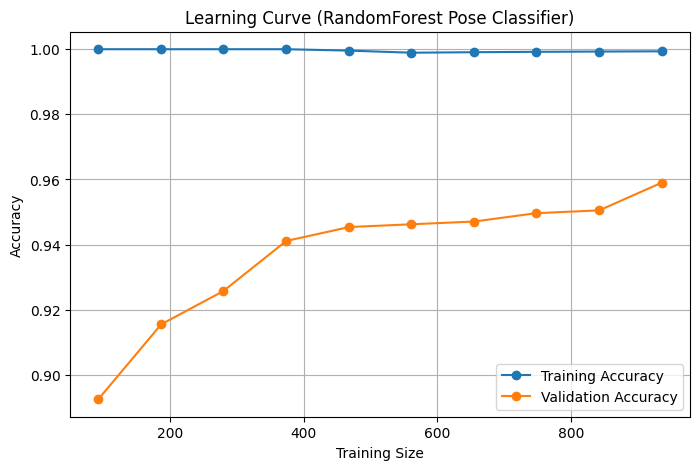

📊 Pose classifier performance:
                precision    recall  f1-score   support

       downdog       0.92      0.98      0.95        56
       goddess       0.95      0.84      0.89        49
         plank       0.93      0.95      0.94        75
     tree_left       0.94      0.94      0.94        17
    tree_right       1.00      0.96      0.98        26
 warrior2_left       0.85      0.88      0.87        26
warrior2_right       0.93      0.95      0.94        44

      accuracy                           0.93       293
     macro avg       0.93      0.93      0.93       293
  weighted avg       0.93      0.93      0.93       293



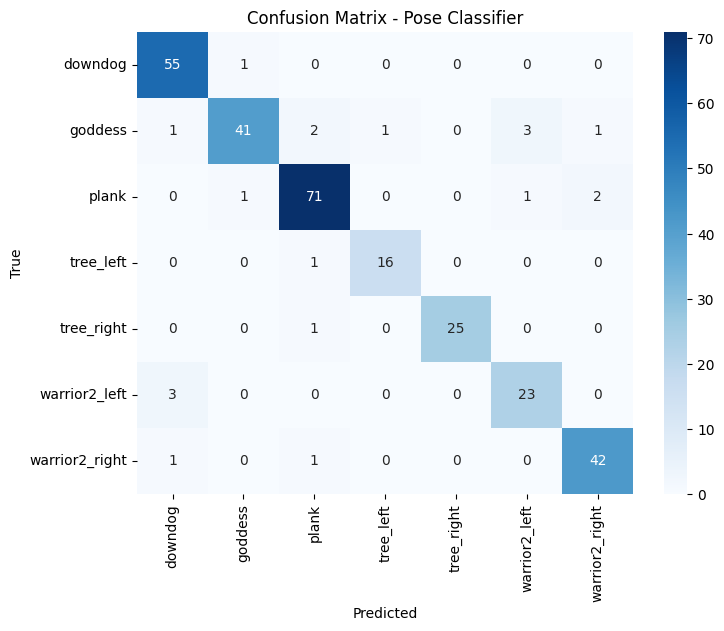

💾 Saved pose classifier to pose_classifier.pkl


In [ ]:
train_pose_classifier("train_angles.csv", "test_angles.csv", model_path="pose_classifier.pkl")

ไฟล์ [pose_classifier.pkl](https://drive.google.com/file/d/1pqr5_fgFT9RZ8V8jfM7kLDR99KhBHxLO/view?usp=sharing)

# ˖⋆˚✿˖° Section 5: Generate incorrect data + Train per-pose correctness models

## Build Incorrect Angles CSV

ฟังก์ชัน `build_incorrect_angles_csv()` สร้าง dataset ของภาพ ท่าที่ทำผิด (incorrect pose) โดยแปลงรูปภาพให้เป็น features (มุมข้อต่อร่างกาย) เช่นเดียวกับชุดข้อมูลปกติ แต่มีป้ายกำกับ `label = 1` เพื่อระบุว่าเป็นตัวอย่างท่าที่ผิดจริง

> ชุดข้อมูล Incorrect Pose ที่เก็บมาเอง: [Incorrect Pose Dataset](https://drive.google.com/drive/folders/1f157MvFaswrHmFCEeocvUPCl6OyN7F0N?usp=drive_link)

In [ ]:
def build_incorrect_angles_csv(incorrect_root, output_csv):
    rows = []
    # loop ผ่านทุกโฟลเดอร์ (class)
    for label in os.listdir(incorrect_root):
        pose_dir = os.path.join(incorrect_root, label)
        if not os.path.isdir(pose_dir):
            continue

        print(f"Processing INCORRECT class folder: {label}")
        # เลือกเฉพาะไฟล์รูป
        img_files = [f for f in os.listdir(pose_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

        # loop ภาพทั้งหมดใน class นั้น
        for img_file in img_files:
            img_path = os.path.join(pose_dir, img_file)
            # โหลดภาพด้วย OpenCV
            image = cv2.imread(img_path)
            if image is None:
                continue

            # Crop คนออกจากภาพด้วย YOLO
            crop_img, crop_box = crop_person_with_yolo(image)
            if crop_img is None:
                continue

            # ใช้ MediaPipe หา keypoints
            keypoints = mediapipe_keypoints_from_image_for_train(crop_img)
            if keypoints is None:
                continue

            # คำนวณมุมข้อต่อ
            angles = compute_angles_from_keypoints(keypoints)
            # แยก tree_left/right, warrior2_left/right
            pose_name = classify_side_for_pose(label, angles)

            # สร้าง 1 แถวข้อมูลสำหรับ CSV
            row = {
                "pose_folder_label": label,
                "pose_name": pose_name,
                "image_path": img_path,
                "label": 1  # incorrect จริง
            }
            for col in FEATURE_COLS:
                row[col] = angles[col]

            rows.append(row)

    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved {len(df)} real incorrect samples to {output_csv}")

In [ ]:
build_incorrect_angles_csv(INCORRECT_PATH, "incorrect_angles_real.csv")

Processing INCORRECT class folder: goddess
Processing INCORRECT class folder: downdog
Processing INCORRECT class folder: plank
Processing INCORRECT class folder: tree
Processing INCORRECT class folder: warrior2
✅ Saved 114 real incorrect samples to incorrect_angles_real.csv


## Train per-pose correctness models

ฟังก์ชัน `augment_around_real_incorrect()` สร้าง synthetic incorrect pose samples (ตัวอย่างท่าที่ทำผิดแบบจำลอง) โดยการ
1. เอาตัวอย่าง incorrect จริง (real incorrect) มาเป็นจุดตั้งต้น
1. สร้างข้อมูลเพิ่มโดย สุ่มเพิ่ม/ลดมุมแต่ละข้อต่อเล็กน้อย (Gaussian noise)
1. ให้ synthetic ทุกตัวมี label = 1 (incorrect)

In [ ]:
def augment_around_real_incorrect(df_incorrect_real_pose, n_aug_per_real=10, noise_std=5.0):
    """
    df_incorrect_real_pose: แถว incorrect จริงของ pose นั้น ๆ
    สร้าง synthetic incorrect จากการ random noise รอบ ๆ มัน
    """
    rows = []
    # loop ผ่านทุก row ของ real incorrect
    for _, row in df_incorrect_real_pose.iterrows():
        # เก็บข้อมูลตัวจริงลง dataset ก่อน
        base = row[FEATURE_COLS].to_dict()
        base["label"] = 1
        rows.append(base)

        # สร้าง synthetic incorrect ด้วย Gaussian Noise
        for _ in range(n_aug_per_real):
            aug = {}
            for col in FEATURE_COLS:
                val = row[col]
                # เพิ่ม noise เล็กน้อย (± noise_std องศา)
                new_val = float(val + np.random.normal(0, noise_std)) # ได้ค่า noise ที่เฉลี่ย = 0, ส่วนเบี่ยงเบน = 5° (ตาม default)
                # จำกัดมุมให้อยู่ในช่วง 0–180°
                new_val = max(0, min(180, new_val))
                aug[col] = new_val
            aug["label"] = 1
            rows.append(aug)
    return pd.DataFrame(rows)

ฟังก์ชัน `train_correctness_for_pose()` ตรวจท่าว่าทำ ถูก (correct) หรือผิด (incorrect)

1. โหลด correct + incorrect จริงสำหรับท่านั้น
1. สร้าง synthetic incorrect ให้สมดุลกับ correct
1. รวมเป็น dataset ของท่านั้นเดียว
1. ให้ weight กับ incorrect จริงมากกว่า
1. train Gradient Boosting
1. plot learning curve & confusion matrix
1. return classifier ว่าทำ ถูก (correct) หรือผิด (incorrect) สำหรับท่านั้น


In [ ]:
def train_correctness_for_pose(
    pose_key,
    df_correct_all,          # มาจาก train_angles.csv (ทั้งหมดของ pose นี้)
    df_incorrect_real_all,   # มาจาก incorrect_angles_real.csv เฉพาะ pose นี้
    target_ratio=1.0
):
    # แยกข้อมูล Correct และ Incorrect เฉพาะท่านี้
    df_correct_pose = df_correct_all[df_correct_all["pose_name"] == pose_key].copy()
    df_incorrect_real_pose = df_incorrect_real_all[df_incorrect_real_all["pose_name"] == pose_key].copy()

    # ถ้า correct หรือ incorrect จริงหาย จะ train ไม่ได้
    if df_correct_pose.empty or df_incorrect_real_pose.empty:
        print(f"⚠️ Pose {pose_key}: missing correct or real incorrect data")
        return None

    # 1) เตรียม correct samples
    df_correct_pose = df_correct_pose[FEATURE_COLS].copy() # เอาเฉพาะ feature มุมข้อต่อ (angles)
    df_correct_pose["label"] = 0 # ตั้ง label = 0 (correct)
    n_correct = len(df_correct_pose) # n_correct คือจำนวน correct จริง

    # 2) กำหนด n_aug_per_real dynamic คำนวณ จำนวน synthetic incorrect ที่ต้องสร้าง
    n_incorrect_real = len(df_incorrect_real_pose)
    if n_incorrect_real > 0:
        # n_aug_per_real = กำหนดให้จำนวน incorrect ~ correct * target_ratio
        n_aug_per_real = max(0, int((n_correct * target_ratio / n_incorrect_real) - 1))
    else:
        n_aug_per_real = 0

    # 3) incorrect จริง + synthetic รอบ incorrect จริง
    df_incorrect_aug = augment_around_real_incorrect(df_incorrect_real_pose, n_aug_per_real=n_aug_per_real)

    # print จำนวนแต่ละ class ก่อน train
    print(f"Pose: {pose_key}")
    print(f"  Correct (original)   : {n_correct}")
    print(f"  Incorrect real       : {n_incorrect_real}")
    print(f"  n_aug_per_real       : {n_aug_per_real}")
    print(f"  Incorrect (augmented): {len(df_incorrect_aug)}")
    print(f"  Total samples        : {n_correct + len(df_incorrect_aug)}\n")

    # รวม correct + incorrect
    df_all = pd.concat([df_correct_pose, df_incorrect_aug], ignore_index=True)

    X = df_all[FEATURE_COLS].values
    y = df_all["label"].values

    # ให้ weight เพิ่มกับ incorrect จริง มากกว่าสังเคราะห์
    sample_weight = np.ones_like(y, dtype=float)
    n_real_incorrect = len(df_incorrect_real_pose)
    sample_weight[:n_real_incorrect] = 3.0  # ถ่วงน้ำหนัก incorrect จริงมากขึ้น
    # incorrect จริงมี weight = 3.0, synthetic incorrect และ correct มี weight = 1.0

    # แบ่ง Train/Validation
    X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
        X, y, sample_weight, test_size=0.2, stratify=y, random_state=42
    )

    # เลือกโมเดล Gradient Boosting
    clf = GradientBoostingClassifier(random_state=42)

    # Learning Curve
    train_sizes, train_scores, val_scores = learning_curve(
        clf,
        X_train,
        y_train,
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring="accuracy",
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, "o-", label="Training Accuracy")
    plt.plot(train_sizes, val_mean, "o-", label="Validation Accuracy")
    plt.title(f"Learning Curve — Correctness Model ({pose_key})")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Train โมเดลจริง (พร้อม sample weight)
    clf.fit(X_train, y_train, sample_weight=w_train)

    # ประเมินบน validation set
    print(f"📊 Correctness model for {pose_key}:")
    y_pred = clf.predict(X_val)
    print(classification_report(y_val, y_pred)) # classification report

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Correct", "Incorrect"],
                yticklabels=["Correct", "Incorrect"])
    plt.title(f"Confusion Matrix — Correctness ({pose_key})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return clf

ฟังก์ชัน `train_correctness_models()` ฝึกโมเดลตรวจสอบ correctness ของทุกท่า (pose) ที่กำหนดไว้ใน POSE_ANGLE_THRESHOLDS

In [ ]:
def train_correctness_models(train_angles_csv, incorrect_angles_csv, out_dir="correctness_models"):
    # สร้างโฟลเดอร์สำหรับเก็บโมเดล
    os.makedirs(out_dir, exist_ok=True)

    # โหลด dataset
    df_correct = pd.read_csv(train_angles_csv)
    df_incorrect_real = pd.read_csv(incorrect_angles_csv)

    # วน loop ผ่านทุกท่า (pose)
    for pose_key in POSE_ANGLE_THRESHOLDS.keys():
        print(f"🧪 Training correctness model for {pose_key} ...")

        # เรียกฟังก์ชัน train_correctness_for_pose
        clf = train_correctness_for_pose(
            pose_key,
            df_correct_all=df_correct,
            df_incorrect_real_all=df_incorrect_real,
            target_ratio=1.0 # ตั้งให้จำนวน incorrect ~ จำนวน correct
        )

        # ข้ามท่าที่ไม่มีข้อมูล
        if clf is None:
            continue

        # เซฟโมเดลลงไฟล์
        model_path = os.path.join(out_dir, f"correctness_{pose_key}.pkl")
        joblib.dump(clf, model_path)
        print(f"💾 Saved correctness model to {model_path}")

🧪 Training correctness model for tree_left ...
Pose: tree_left
  Correct (original)   : 54
  Incorrect real       : 13
  n_aug_per_real       : 3
  Incorrect (augmented): 52
  Total samples        : 106



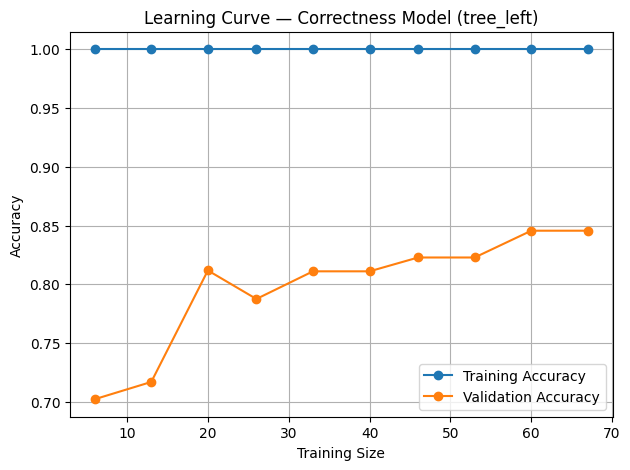

📊 Correctness model for tree_left:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.92      1.00      0.96        11

    accuracy                           0.95        22
   macro avg       0.96      0.95      0.95        22
weighted avg       0.96      0.95      0.95        22



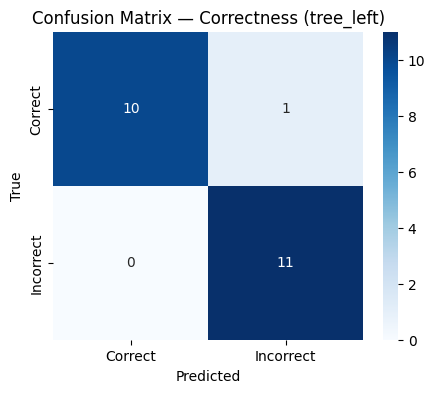

💾 Saved correctness model to correctness_models/correctness_tree_left.pkl
🧪 Training correctness model for tree_right ...
Pose: tree_right
  Correct (original)   : 94
  Incorrect real       : 13
  n_aug_per_real       : 6
  Incorrect (augmented): 91
  Total samples        : 185



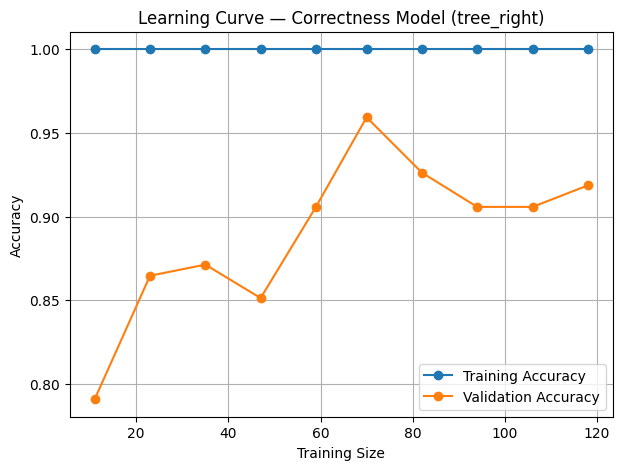

📊 Correctness model for tree_right:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       0.90      1.00      0.95        18

    accuracy                           0.95        37
   macro avg       0.95      0.95      0.95        37
weighted avg       0.95      0.95      0.95        37



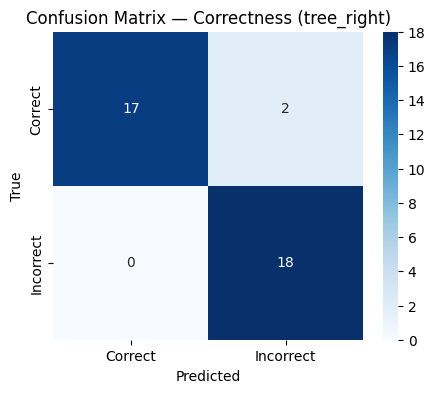

💾 Saved correctness model to correctness_models/correctness_tree_right.pkl
🧪 Training correctness model for warrior2_left ...
Pose: warrior2_left
  Correct (original)   : 89
  Incorrect real       : 14
  n_aug_per_real       : 5
  Incorrect (augmented): 84
  Total samples        : 173



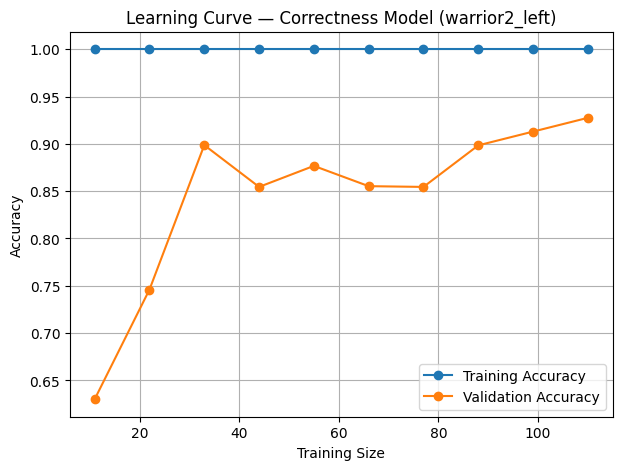

📊 Correctness model for warrior2_left:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       0.94      0.94      0.94        17

    accuracy                           0.94        35
   macro avg       0.94      0.94      0.94        35
weighted avg       0.94      0.94      0.94        35



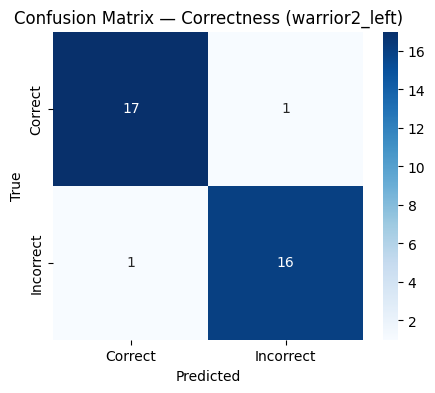

💾 Saved correctness model to correctness_models/correctness_warrior2_left.pkl
🧪 Training correctness model for warrior2_right ...
Pose: warrior2_right
  Correct (original)   : 155
  Incorrect real       : 16
  n_aug_per_real       : 8
  Incorrect (augmented): 144
  Total samples        : 299



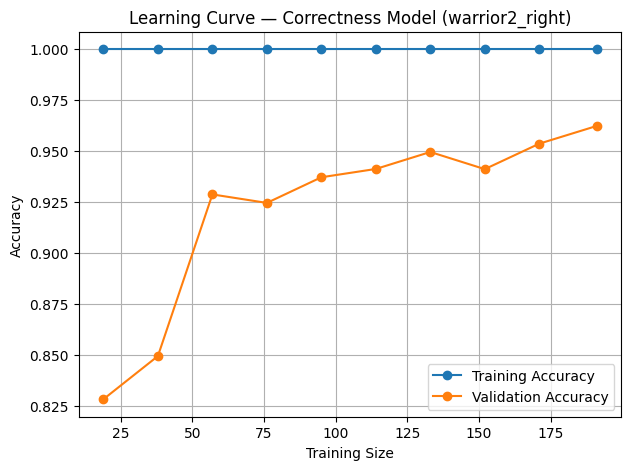

📊 Correctness model for warrior2_right:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        31
           1       0.91      1.00      0.95        29

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



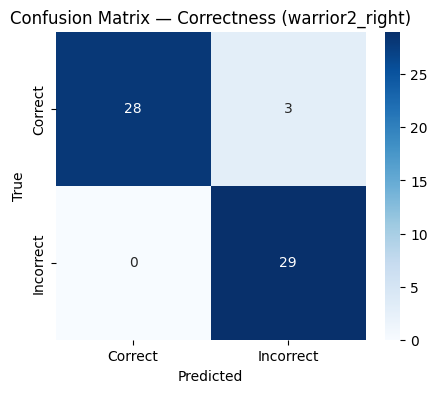

💾 Saved correctness model to correctness_models/correctness_warrior2_right.pkl
🧪 Training correctness model for downdog ...
Pose: downdog
  Correct (original)   : 189
  Incorrect real       : 20
  n_aug_per_real       : 8
  Incorrect (augmented): 180
  Total samples        : 369



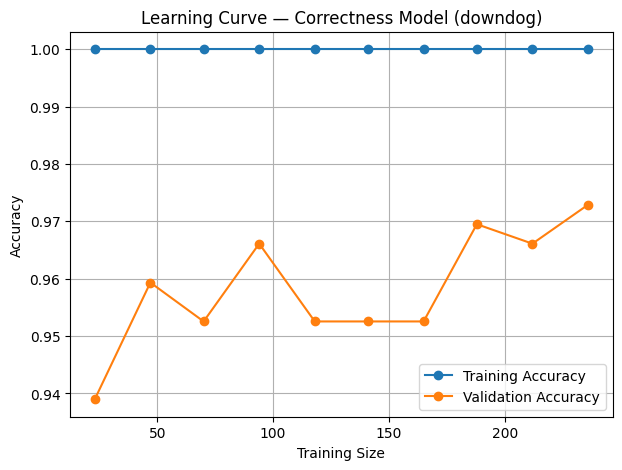

📊 Correctness model for downdog:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        38
           1       0.95      1.00      0.97        36

    accuracy                           0.97        74
   macro avg       0.97      0.97      0.97        74
weighted avg       0.97      0.97      0.97        74



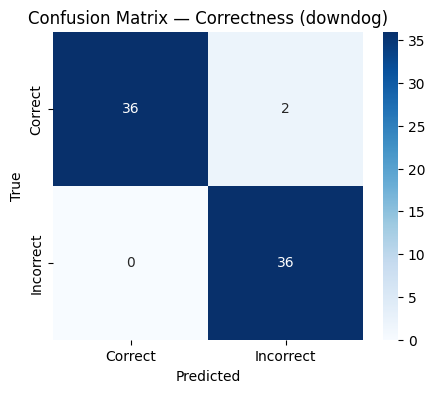

💾 Saved correctness model to correctness_models/correctness_downdog.pkl
🧪 Training correctness model for plank ...
Pose: plank
  Correct (original)   : 258
  Incorrect real       : 26
  n_aug_per_real       : 8
  Incorrect (augmented): 234
  Total samples        : 492



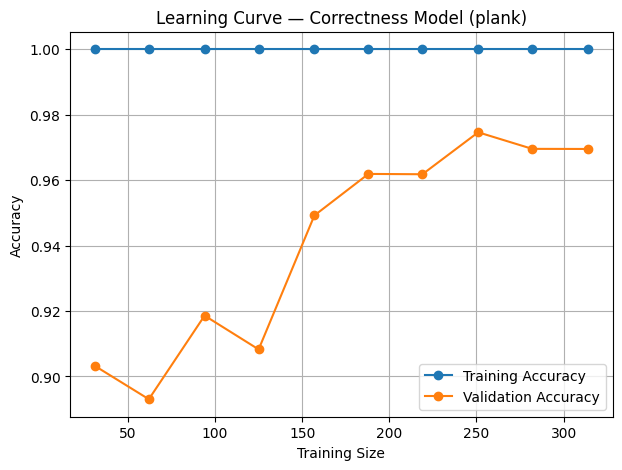

📊 Correctness model for plank:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.96      1.00      0.98        47

    accuracy                           0.98        99
   macro avg       0.98      0.98      0.98        99
weighted avg       0.98      0.98      0.98        99



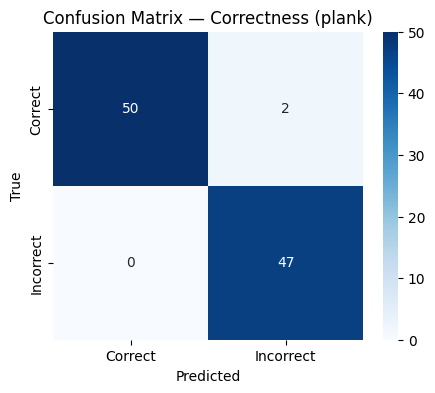

💾 Saved correctness model to correctness_models/correctness_plank.pkl
🧪 Training correctness model for goddess ...
Pose: goddess
  Correct (original)   : 165
  Incorrect real       : 12
  n_aug_per_real       : 12
  Incorrect (augmented): 156
  Total samples        : 321



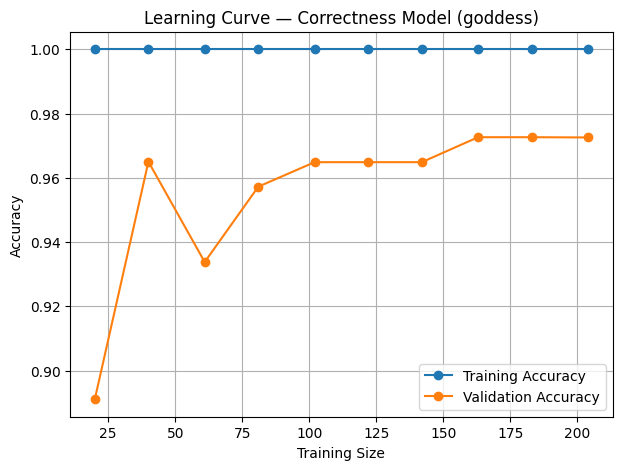

📊 Correctness model for goddess:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        33
           1       0.91      0.97      0.94        32

    accuracy                           0.94        65
   macro avg       0.94      0.94      0.94        65
weighted avg       0.94      0.94      0.94        65



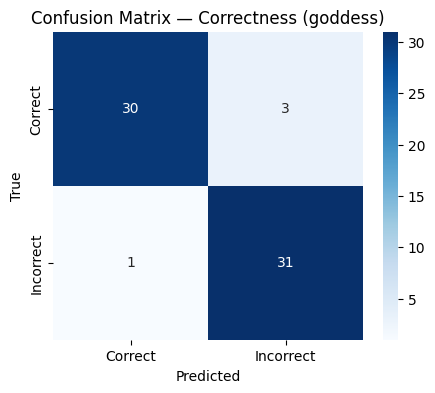

💾 Saved correctness model to correctness_models/correctness_goddess.pkl


In [ ]:
train_correctness_models("train_angles.csv", "incorrect_angles_real.csv", out_dir="correctness_models")

โฟลเดอร์ [correctness_models](https://drive.google.com/drive/folders/1X0JUsnfypYb-Skbr4TouirzVx9inX0M0?usp=sharing)

# ˖⋆˚✿˖° Section 6: Rule-based Threshold + Hybrid Correctness

ฟังก์ชัน `get_wrong_joints_by_threshold()` ตรวจสอบ correctness ของแต่ละ joint ของท่าโยคะ (pose) โดยเปรียบเทียบมุม (angles) ของ joint แต่ละตัวกับ range ของมุมที่ถูกต้อง ที่กำหนดไว้ใน POSE_ANGLE_THRESHOLDS

In [ ]:
def get_wrong_joints_by_threshold(pose_name, angles, relax=0):
    """
    ตรวจว่ามุมแต่ละ joint อยู่ใน range ถูกต้องของท่าหรือไม่
    pose_name : str (เช่น 'downdog')
    angles : dict {'left_knee': 175, 'right_knee': ...}
    relax : อนุโลม +- องศา เช่น relax=5 เพิ่ม tolerance

    return: list ของ joint ที่ผิด
    """

    # ถ้าท่าไม่อยู่ใน dictionary ของ threshold return ว่าง
    if pose_name not in POSE_ANGLE_THRESHOLDS:
        return []  # ถ้าท่านี้ไม่มี rule ให้ถือว่าถูกเสมอ

    wrong = [] # list สำหรับเก็บ joint ที่ผิด
    rules = POSE_ANGLE_THRESHOLDS[pose_name] # dict ของ joint กับ range ของมุม

    # วน loop ทุก joint ของท่านั้น
    for joint, (low, high) in rules.items():
        # ข้าม joint ที่ไม่มีข้อมูลใน angles
        if joint not in angles:
            continue

        # ขยาย range ตาม relax
        low_r = low - relax
        high_r = high + relax

        a = angles[joint] # มุมของ joint ที่เราจะตรวจ

        # ถ้ามุม a ไม่อยู่ในช่วงที่อนุโลม เพิ่ม joint นั้นลง wrong
        if not (low_r <= a <= high_r):
            wrong.append(joint)

    return wrong

ฟังก์ชัน `hybrid_correctness()` เป็น Hybrid Correctness Checker สำหรับท่าโยคะ โดยใช้ 2 กลไก:
1. `Machine Learning (ML)` โมเดล clf ที่เทรนมาเพื่อทำนายว่าท่า correct หรือ incorrect
2. `Rule-based threshold` ตรวจสอบมุม joint กับช่วงมุมที่ถูกต้อง (POSE_ANGLE_THRESHOLDS)

In [ ]:
def hybrid_correctness(pose, angles, clf_tuple):
    """
    Return:
        {
            "correct": bool,
            "wrong_joints": list,
            "source": "ml" | "rule" | "ml_then_rule" | "threshold_secure"
        }
    """

    # กรณีไม่มีโมเดล ML ใช้ rule-based อย่างเดียว
    if clf_tuple is None:
        wrong = get_wrong_joints_by_threshold(pose, angles)
        return {
            "correct": (len(wrong) == 0), # คืน correct=True ถ้าไม่มี joint ผิด
            "wrong_joints": wrong,
            "source": "threshold_secure" # บ่งบอกว่าตัดสินใจจาก threshold
        }

    # unpack
    if isinstance(clf_tuple, tuple):
        clf = clf_tuple[0]
        feat_cols = clf_tuple[1] if len(clf_tuple) > 1 else FEATURE_COLS
    elif isinstance(clf_tuple, dict):
        clf = clf_tuple["model"]
        feat_cols = clf_tuple["feat_cols"]
    else:
        clf = clf_tuple
        feat_cols = FEATURE_COLS

    # ML decision
    x = np.array([[angles[c] for c in feat_cols]]) # สร้าง feature vector จาก angles ตาม feat_cols
    pred = clf.predict(x)[0] # ทำนาย 0=correct, 1=incorrect
    ml_incorrect = (pred == 1) # ml_incorrect=True ถ้า ML ทำนายว่า incorrect

    # Rule-based check
    wrong = get_wrong_joints_by_threshold(pose, angles)

    # Final decision logic

    # CASE 1 — ML = correct, rule no errors
    if not ml_incorrect and wrong == []:
        return {"correct": True, "wrong_joints": [], "source": "ml"}

    # CASE 2 — ML = incorrect, rule shows specific joints wrong
    if ml_incorrect and wrong != []:
        return {"correct": False, "wrong_joints": wrong, "source": "ml_then_rule"}

    # CASE 3 — ML = incorrect, but rule = no issues → TRUST RULE
    if ml_incorrect and wrong == []:
        return {"correct": True, "wrong_joints": [], "source": "rule_override"}

    # CASE 4 — ML correct but rule says wrong → TRUST RULE
    if not ml_incorrect and wrong != []:
        return {"correct": False, "wrong_joints": wrong, "source": "threshold_secure"}

    # fallback
    return {"correct": True, "wrong_joints": [], "source": "fallback"}

# ˖⋆˚✿˖° Section 7: Inference

ฟังก์ชัน `load_models_for_inference()`  โหลดโมเดลที่จำเป็นสำหรับการทดสอบ (inference) ของระบบโยคะ
1. `Pose Classifier` โมเดลทำนายท่าโยคะ (pose_name)
1. `Correctness Path` ที่เก็บโมเดลตรวจสอบความถูกต้องของแต่ละท่า (correct / incorrect)

In [ ]:
def load_models_for_inference(
    pose_clf_path="pose_classifier.pkl",
    correctness_dir="correctness_models"
):
    # โหลด pose classifier จากไฟล์ .pkl
    pose_clf = joblib.load(pose_clf_path)
    # สร้าง dict ว่าง correctness_models
    correctness_models = {}
    # วน loop ทุกท่าโยคะ (POSE_ANGLE_THRESHOLDS.keys())
    for pose_key in POSE_ANGLE_THRESHOLDS.keys():
        # ตรวจว่ามีไฟล์โมเดล correctness ของท่านั้นหรือไม่ (correctness_<pose>.pkl)
        model_path = os.path.join(correctness_dir, f"correctness_{pose_key}.pkl")
        if os.path.exists(model_path):
            # ถ้ามี โหลดด้วย joblib.load แล้วเก็บใน dict โดยใช้ pose_key เป็น key
            correctness_models[pose_key] = joblib.load(model_path)
    return pose_clf, correctness_models

## Images

ฟังก์ชัน `infer_image()` ทำหน้าที่ วิเคราะห์ภาพเดียว

1. หา bounding box ของคนในภาพ
1. ดึง keypoints ของร่างกายด้วย MediaPipe
1. คำนวณมุมของแต่ละ joint
1. ทำนายท่าโยคะ (pose)
1. ประเมินความถูกต้อง (correct / incorrect) แบบ hybrid
1. คืนข้อมูลครบถ้วนสำหรับการวิเคราะห์หรือ visualization

In [ ]:
def infer_image(image_bgr, pose_clf, correctness_models):
    """
    Return dict:
      {
        "pose": str,
        "correct": bool,
        "wrong_joints": list,
        "decision_source": str,
        "angles": dict,
        "keypoints": dict,
        "crop": np.ndarray
      }
    """

    # 1) Crop person with YOLO
    crop, crop_box = crop_person_with_yolo(image_bgr)
    if crop is None:
        return None

    # 2) MediaPipe keypoints
    keypoints = mediapipe_keypoints_from_image(crop)
    if keypoints is None:
        return None

    # 3) Compute angles
    angles = compute_angles_from_keypoints(keypoints)

    # 4) Predict pose
    x_pose = pd.DataFrame([angles], columns=FEATURE_COLS)
    pose_pred = pose_clf.predict(x_pose)[0]

    # 5) Hybrid correctness
    clf_tuple = correctness_models.get(pose_pred, None) # ดึง correctness model สำหรับท่า pose_pred จาก correctness_models

    #  hybrid เป็น dict {correct, wrong_joints, source}
    hybrid = hybrid_correctness( # ใช้ hybrid_correctness เพื่อตัดสินว่า ท่านี้ถูกหรือผิด
        pose=pose_pred,
        angles=angles,
        clf_tuple=clf_tuple
    )

    # 6) Return complete result
    return {
        "pose": pose_pred,
        "correct": hybrid["correct"],
        "wrong_joints": hybrid["wrong_joints"],
        "decision_source": hybrid["source"],
        "angles": angles,
        "keypoints": keypoints,
        "crop": crop,
        "crop_box": crop_box
    }

**Visualization**

ฟังก์ชัน `visualize_correctness()` ใช้ วาด skeleton ของร่างกาย บนภาพและ เน้น joint ที่ผิด ตามรายการ wrong_joints ที่ตรวจพบจากโมเดลหรือ threshold
* Skeleton joints ถูกวาดสีเขียวหากถูกต้อง
* Skeleton joints หรือ keypoints ที่ผิด ถูกวาดสีแดง
* สามารถปรับขนาดภาพ (target_width) พร้อมสเกล keypoints ให้ตรง

In [ ]:
def visualize_correctness(image_bgr, keypoints, wrong_joints, angles, target_width=None):
    img = image_bgr.copy() # ทำ copy ของภาพต้นฉบับ
    scale_x = 1.0
    scale_y = 1.0

    # ไม่เอา nose
    IGNORE_POINTS = ["nose"]

    # ฟังก์ชันช่วยตรวจสอบว่า point (x,y[,v]) ไม่เป็น None และไม่ใช่ NaN
    def safe_point(pt):
        if pt is None:
            return None
        if len(pt) == 3:
            x, y, v = pt
        else:
            x, y = pt
            v = 1.0
        if x is None or y is None or np.isnan(x) or np.isnan(y):
            return None
        return int(x), int(y), v

    # Mapping ระบุว่าแต่ละ joint ที่ผิดเกี่ยวข้องกับ keypoints ไหนบ้าง
    JOINT_TO_KEYPOINT = {
        "left_elbow":    ["left_shoulder", "left_elbow", "left_wrist"],
        "right_elbow":   ["right_shoulder", "right_elbow", "right_wrist"],
        "left_knee":     ["left_hip", "left_knee", "left_ankle"],
        "right_knee":    ["right_hip", "right_knee", "right_ankle"],
        "left_hip":      ["left_shoulder", "left_hip", "left_knee"],
        "right_hip":     ["right_shoulder", "right_hip", "right_knee"],
    }

    # ตรวจสอบว่าการเชื่อมต่อระหว่าง joint a→b เป็น wrong connection หรือไม่
    def is_wrong_connection(a, b):
        for joint, kps in JOINT_TO_KEYPOINT.items():
            if joint in wrong_joints and (a in kps or b in kps):
                return True
        return False

    # ปรับขนาดภาพและ keypoints (ถ้ามี target_width)
    if target_width is not None:
        h, w = img.shape[:2]
        ratio = target_width / w
        new_h = int(h * ratio)

        img = cv2.resize(img, (target_width, new_h))

        scale_x = ratio
        scale_y = ratio

        # scale keypoints
        new_keypoints = {}
        for k, v in keypoints.items():
            if v is None:
                new_keypoints[k] = None
                continue
            if len(v) == 3:
                x, y, vis = v
                new_keypoints[k] = (x * scale_x, y * scale_y, vis)
            else:
                x, y = v
                new_keypoints[k] = (x * scale_x, y * scale_y)
        keypoints = new_keypoints

    # วาด skeleton lines
    for a, b in COCO_CONNECTIONS:
        # ข้ามคู่ที่ keypoints ไม่มีในข้อมูล หรืออยู่ใน IGNORE_POINTS (เช่น nose)
        if a not in keypoints or b not in keypoints:
            continue
        if a in IGNORE_POINTS or b in IGNORE_POINTS:
            continue

        # ตรวจสอบว่า keypoints ถูกต้อง (ไม่เป็น None หรือ NaN)
        pt1 = safe_point(keypoints[a])
        pt2 = safe_point(keypoints[b])
        if pt1 is None or pt2 is None:
            continue

        # v1 และ v2 คือ visibility/confidence ของ keypoints ถ้า confidence น้อยกว่า 0.5 ข้าม (ไม่วาด)
        x1,y1,v1 = pt1
        x2,y2,v2 = pt2
        if v1 < 0.5 or v2 < 0.5:
            continue

        # default = เขียว, 2px
        color = (0,255,0)
        thickness = 2

        # ถ้าเป็น joint ผิด (is_wrong_connection) = แดง, 3px
        if is_wrong_connection(a, b):
            color = (0,0,255)
            thickness = 3

        # วาดเส้นเชื่อม skeleton ระหว่าง (x1,y1) → (x2,y2)
        cv2.line(img, (x1,y1), (x2,y2), color, thickness)

    # วาด keypoints (จุดแต่ละ joint)
    for name, pt in keypoints.items():
        # ข้ามจุดที่ไม่ต้องวาด (nose)
        if name in IGNORE_POINTS:
            continue

        # ตรวจสอบ keypoint ว่าถูกต้องและ confidence ≥ 0.5
        pt2 = safe_point(pt)
        if pt2 is None:
            continue
        x,y,v = pt2
        if v < 0.5:
            continue

        # default: keypoint เขียว ขนาด 5
        color = (0,255,0)
        size = 5

        # ถ้า keypoint นี้เกี่ยวข้องกับ joint ที่ผิด = แดง ขนาด 7
        for joint, kps in JOINT_TO_KEYPOINT.items():
            if joint in wrong_joints and name in kps:
                color = (0,0,255)
                size = 7

        # วาด วงกลมเต็ม (filled circle) ที่ keypoint
        cv2.circle(img, (x,y), size, color, -1)

    return img

**Inference + Visualization**

ฟังก์ชัน `infer_and_visualize_image()` รวมการทำ inference ของ pose + correctness และ visualize keypoints กับ joint ที่ผิด ลงบนภาพ พร้อมตัวเลือกบันทึกและแสดงผล

In [ ]:
def infer_and_visualize_image(
    img_path,
    pose_clf,
    correctness_models,
    target_width=300,
    save_path=None,
    show=True,
    verbose=True
):
    """
    ทำ pose + correctness inference และ visualize keypoints + wrong joints

    Parameters:
    - img_path: str, path ของรูปภาพ
    - pose_clf: โมเดล pose classifier
    - correctness_models: dict ของ correctness models
    - target_width: int, ขนาด width ของ crop สำหรับ visualize
    - save_path: str, ถ้าไม่ None จะบันทึกภาพผลลัพธ์ลง path นี้
    - show: bool, ถ้า True จะแสดงผลด้วย cv2_imshow
    - verbose: bool, ถ้า True จะแสดง print output ของ pose + correctness

    Returns:
    - result: dict จาก infer_image หรือ None
    - out_img: BGR image ที่ visualize keypoints
    """
    # โหลดภาพ
    img = cv2.imread(img_path)
    if img is None:
        if verbose:
            print(f"⚠️ ไม่สามารถโหลดภาพ: {img_path}")
        return None, None

    # ทำ pose + correctness inference
    result = infer_image(img, pose_clf, correctness_models)
    if result is None:
        if verbose:
            print("⚠️ ไม่พบ pose ในภาพ")
        return None, img

    # Visualize correctness
    out_img = visualize_correctness(
        result["crop"],
        result["keypoints"],
        result["wrong_joints"],
        result["angles"],
        target_width=target_width
    )

    # แสดงผลลัพธ์แบบข้อความ
    if verbose:
        print(f"Pose: {result['pose']} | Correct: {result['correct']} | Source: {result['decision_source']}")
        print("Wrong joints:", result["wrong_joints"])

    # บันทึกภาพ (ถ้ามี path)
    if save_path:
        cv2.imwrite(save_path, out_img)

    # แสดงภาพ (ถ้า show=True)
    if show:
        cv2_imshow(out_img)

    # คืนค่า ผลลัพธ์ inference (result) และ ภาพที่ visualize (out_img)
    return result, out_img

### ᯓᰔ Result

In [ ]:
pose_clf, correctness_models = load_models_for_inference(
    "/content/drive/MyDrive/CP461/CSV_File/pose_classifier.pkl",
    "/content/drive/MyDrive/CP461/CSV_File/correctness_models"
)

ทดสอบกับท่าที่ปฏิบัติถูกต้อง

Pose: goddess | Correct: True | Source: ml
Wrong joints: []


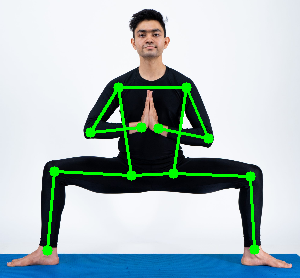

In [ ]:
result, out_img = infer_and_visualize_image(
    "/content/goddess.jpg",
    pose_clf,
    correctness_models,
    target_width=300
)

ทดสอบกับท่าที่ปฏิบัติไม่ถูกต้อง

Pose: goddess | Correct: False | Source: ml_then_rule
Wrong joints: ['left_hip', 'right_hip']


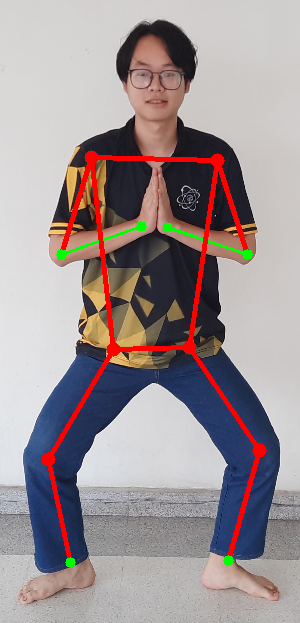

In [ ]:
result, out_img = infer_and_visualize_image(
    "/content/goddess_incorrect.jpg",
    pose_clf,
    correctness_models,
    target_width=300
)

ทดสอบกับท่าที่ปฏิบัติถูกต้องและท่าที่ปฏิบัติไม่ถูกต้องในแต่ละท่า

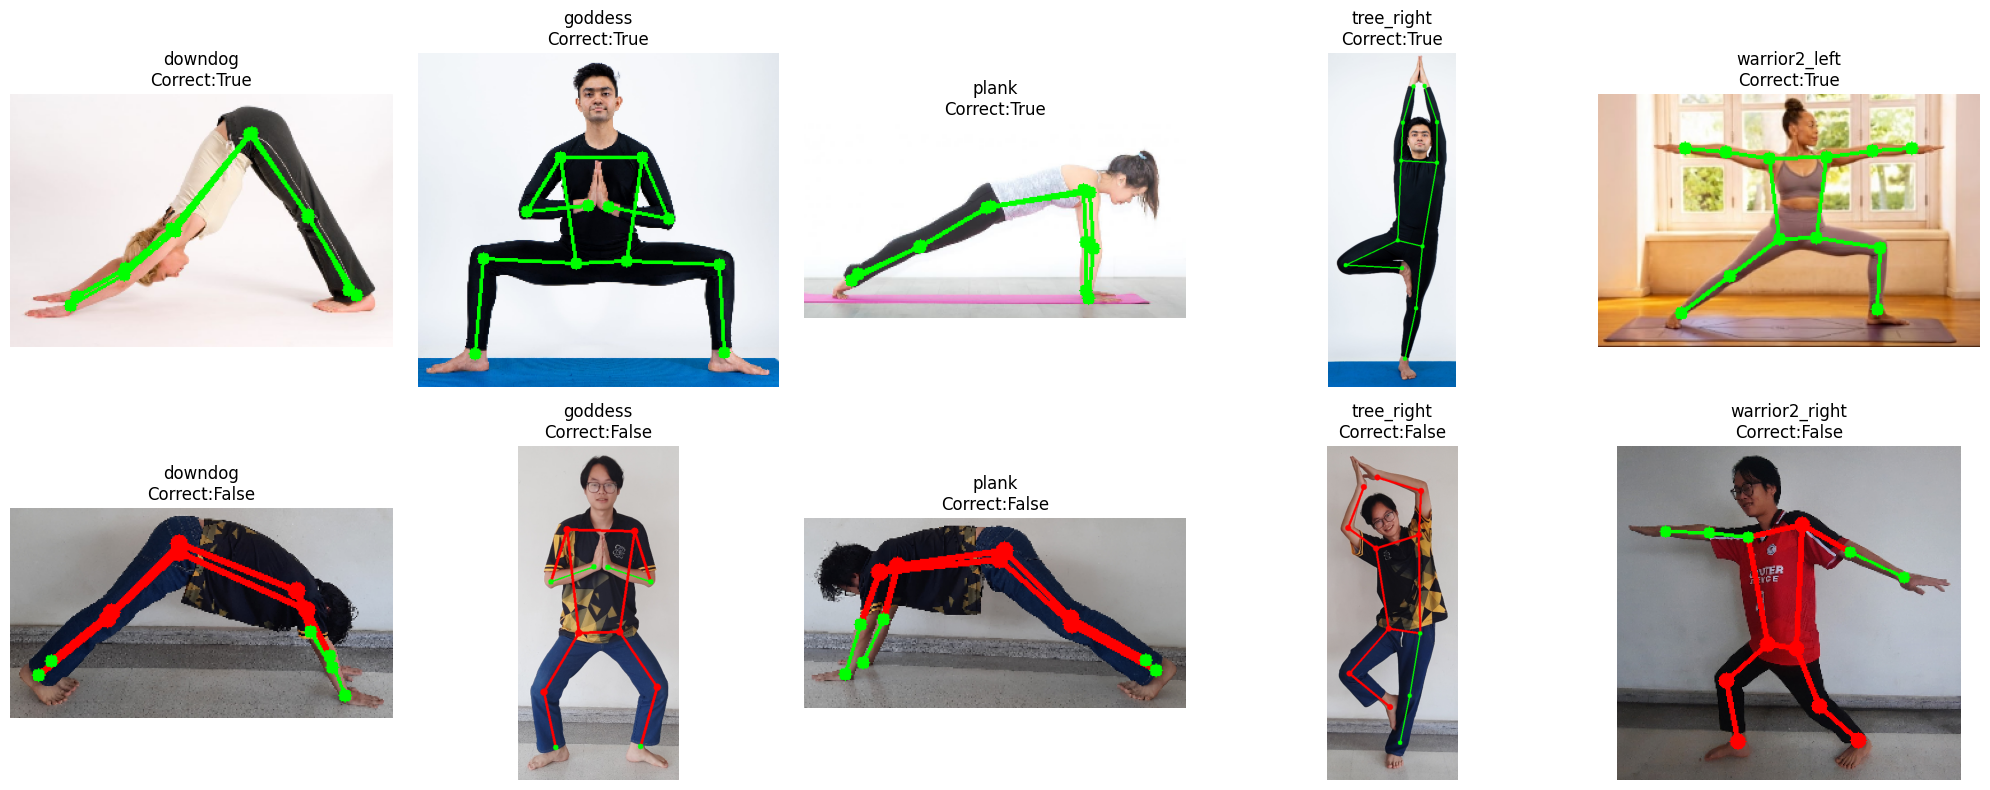

In [ ]:
# Paths
folders = [
    "/content/drive/MyDrive/TEST/correct",
    "/content/drive/MyDrive/TEST/incorrect"
]

# เตรียม figure matplotlib (2 แถว 5 คอลัมน์)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# Loop ผ่านโฟลเดอร์ + ไฟล์
for idx, folder in enumerate(folders):
    files = sorted(os.listdir(folder))[:5]  # เอา 5 รูปแรก
    for j, fname in enumerate(files):
        img_path = os.path.join(folder, fname)

        # ใช้ฟังก์ชัน infer + visualize
        result, out_img = infer_and_visualize_image(
            img_path,
            pose_clf,
            correctness_models,
            target_width = 300,
            show = False,        # ไม่ใช้ cv2_imshow
            verbose = False
        )

        # แปลง BGR -> RGB สำหรับ matplotlib
        if out_img is not None:
            out_rgb = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        else:
            img = cv2.imread(img_path)
            out_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # plot
        axes[idx*5 + j].imshow(out_rgb)
        axes[idx*5 + j].axis("off")
        if result is not None:
            axes[idx*5 + j].set_title(f"{result['pose']}\nCorrect:{result['correct']}")
        else:
            axes[idx*5 + j].set_title("No pose detected")

plt.tight_layout()
plt.show()

## Video

ฟังก์ชัน `visualize_on_original_frame()` วาด skeleton และ keypoints ลงบน original frame หลังจากที่เราเคย crop คนออกมาเพื่อทำ pose + correctness inference

In [ ]:
def visualize_on_original_frame(frame, keypoints_crop, crop_box, wrong_joints):
    # แยกตำแหน่ง crop
    x1, y1, x2, y2 = crop_box
    frame_vis = frame.copy()

    # แปลง keypoints กลับไป original frame
    keypoints_orig = {}
    for k, (kx, ky) in keypoints_crop.items():
        keypoints_orig[k] = (int(kx + x1), int(ky + y1))

    # วาดเส้น skeleton
    for joint_a, joint_b in COCO_CONNECTIONS: # วนทุกคู่ joint ที่เชื่อมกัน (COCO_CONNECTIONS)
        if joint_a in keypoints_orig and joint_b in keypoints_orig: # ถ้า joint ตัวไหนอยู่ใน wrong_joints ใช้ สีแดง
            color = (0,0,255) if joint_a in wrong_joints or joint_b in wrong_joints else (0,255,0) # ถ้าไม่ผิด ใช้ สีเขียว
            cv2.line(frame_vis, keypoints_orig[joint_a], keypoints_orig[joint_b], color, 2) # วาดเส้นด้วย cv2.line

    # วาดจุด (ไม่เอา nose)
    for k, (orig_x, orig_y) in keypoints_orig.items():
        if k == "nose":
            continue
        color = (0,0,255) if k in wrong_joints else (0,255,0) # ถ้า joint ผิด สีแดง, ถ้า joint ถูก สีเขียว
        cv2.circle(frame_vis, (orig_x, orig_y), 5, color, -1) # วาดวงกลม radius = 5 ด้วย cv2.circle

    return frame_vis

ฟังก์ชัน `process_video_with_pose_original()`
1. Pose inference ทำนายท่า
1. Correctness inference ตรวจ joint ผิด
1. Visualize skeleton + keypoints บน original frame
1. บันทึกเป็นวิดีโอใหม่

In [ ]:
def process_video_with_pose_original(video_path, output_path, pose_clf, correctness_models, verbose=True):
    """
    ทำ pose + correctness inference บนวิดีโอ original size

    Parameters:
    - video_path: str, path ของวิดีโอ input
    - output_path: str, path ของวิดีโอ output
    - pose_clf: โมเดล pose classifier
    - correctness_models: dict ของ correctness models
    - verbose: bool, ถ้า True จะแสดง log

    Returns:
    - None (บันทึกวิดีโอ output)
    """
    # อ่านวิดีโอ
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"ไม่สามารถเปิดวิดีโอ: {video_path}")
        return

    # ดึงข้อมูล video
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Processing video: {total_frames} frames at {fps} FPS")

    # สร้าง VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    frame_written = 0

    # วนอ่านทุก frame
    for _ in tqdm(range(total_frames), desc="Processing frames"):
        ret, frame = cap.read()
        if not ret:
            break

        # ทำ pose + correctness inference + visualize
        try:
            # ทำนาย pose และ correctness
            result = infer_image(frame, pose_clf, correctness_models)
            if result is not None:
                # วาด skeleton + keypoints บน original frame
                vis_frame = visualize_on_original_frame(frame, result["keypoints"], result["crop_box"], result["wrong_joints"])
                if verbose:
                    print(f"Frame {frame_written}: Pose={result['pose']} Correct={result['correct']}")
            else:
                vis_frame = frame
        except Exception as e:
            if verbose:
                print(f"Error frame {frame_written}: {e}")
            vis_frame = frame

        # เขียน frame ลงวิดีโอ output
        out.write(vis_frame)
        frame_written += 1

    # ปล่อย resource และปิด video
    cap.release()
    out.release()
    print(f"\nSaved video with keypoints: {output_path}")

### ᯓᰔ Result

In [ ]:
process_video_with_pose_original(
    video_path="/content/drive/MyDrive/TEST/vdo/downdog_vdo.mp4",
    output_path="/content/drive/MyDrive/TEST/vdo_output/downdog_output_vdo.mp4",
    pose_clf=pose_clf,
    correctness_models=correctness_models,
    verbose=False
)

Processing video: 283 frames at 30.000706730429457 FPS


Processing frames: 100%|██████████| 283/283 [00:46<00:00,  6.07it/s]


Saved video with keypoints: /content/drive/MyDrive/TEST/vdo_output/downdog_output_vdo.mp4


<div style="display: flex; justify-content: space-between;">
        <img src="https://drive.google.com/uc?export=view&id=1RaNL7QRP20BQX_RBvZRuBlxBG-u0yPSL" height="400">
</div>

In [ ]:
process_video_with_pose_original(
    video_path="/content/drive/MyDrive/TEST/vdo/goddess_vdo.mp4",
    output_path="/content/drive/MyDrive/TEST/vdo_output/goddess_output_vdo.mp4",
    pose_clf=pose_clf,
    correctness_models=correctness_models,
    verbose=False
)

Processing video: 175 frames at 30.009260000228643 FPS


Processing frames: 100%|██████████| 175/175 [00:27<00:00,  6.47it/s]


Saved video with keypoints: /content/drive/MyDrive/TEST/vdo_output/goddess_output_vdo.mp4


<div style="display: flex; justify-content: space-between;">
        <img src="https://drive.google.com/uc?export=view&id=1o7NjMcdrc8ndN9RHd0oem7Z9iDL2zRaY" height="400">
</div>